In [5]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
dataset=pd.read_csv("/content/delhi_aqi.csv",header=0,parse_dates=[0],index_col=0)

In [7]:
dataset.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
date,,,,,,,,
2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61


In [8]:
# Creating a DataFrame
df = pd.DataFrame(dataset)

In [ ]:
# Checking for null values
df.isnull().sum()

co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

In [9]:
df.duplicated().sum()

0

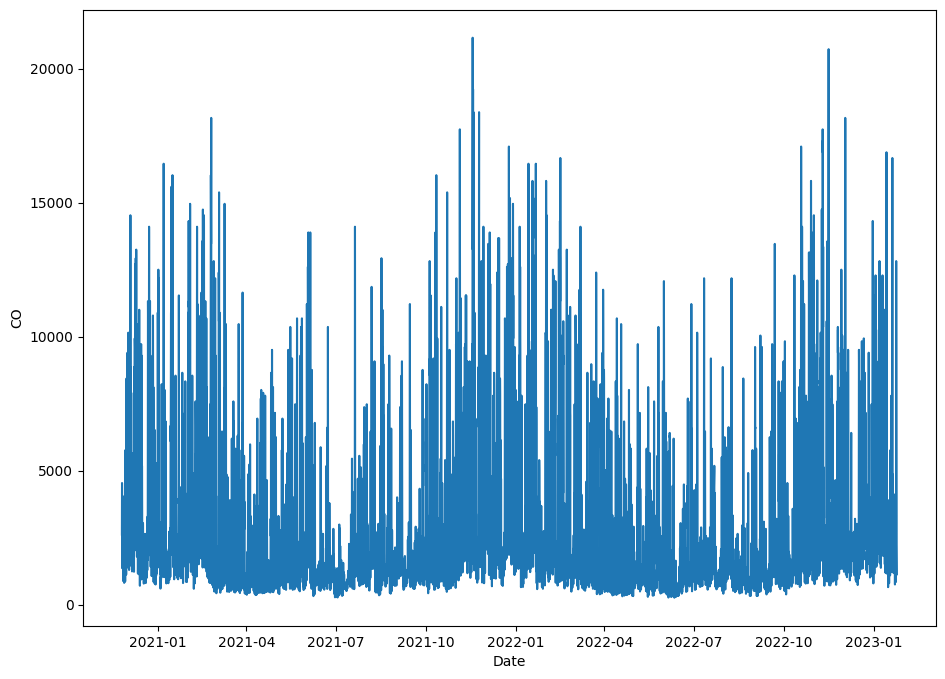

In [10]:
plt.plot(df['co'])
plt.xlabel('Date')
plt.ylabel('CO')
plt.gcf().set_size_inches(11,8)


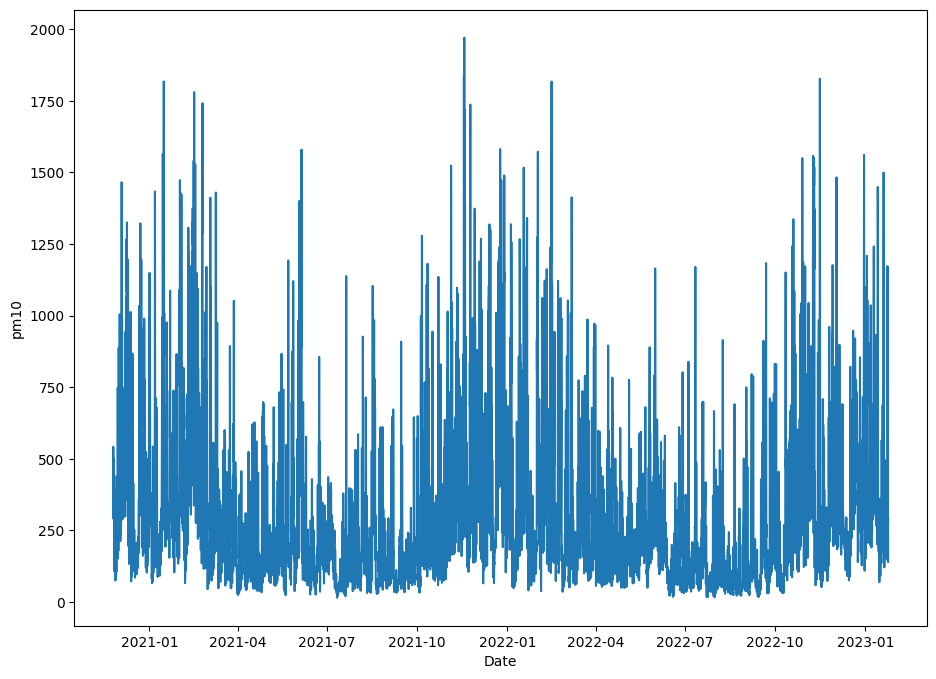

In [11]:
plt.plot(df['pm10'])
plt.xlabel('Date')
plt.ylabel('pm10')
plt.gcf().set_size_inches(11,8)

#Calculate the QoQ growth

In [12]:
df['diff']=0
series=df['co'].pct_change().dropna().values.reshape(-1,1)
df.loc[1:,'diff']=series

<ipython-input-12-51c525875dce>:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[1:,'diff']=series


In [13]:
df

,co,no,no2,o3,so2,pm2_5,pm10,nh3,diff
date,,,,,,,,,
2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63,0.000000
2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04,0.387756
2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14,0.250001
2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13,0.000000
2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61,-0.035295
...,...,...,...,...,...,...,...,...,...
2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27,-0.175000
2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12,-0.015150
2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54,0.107692


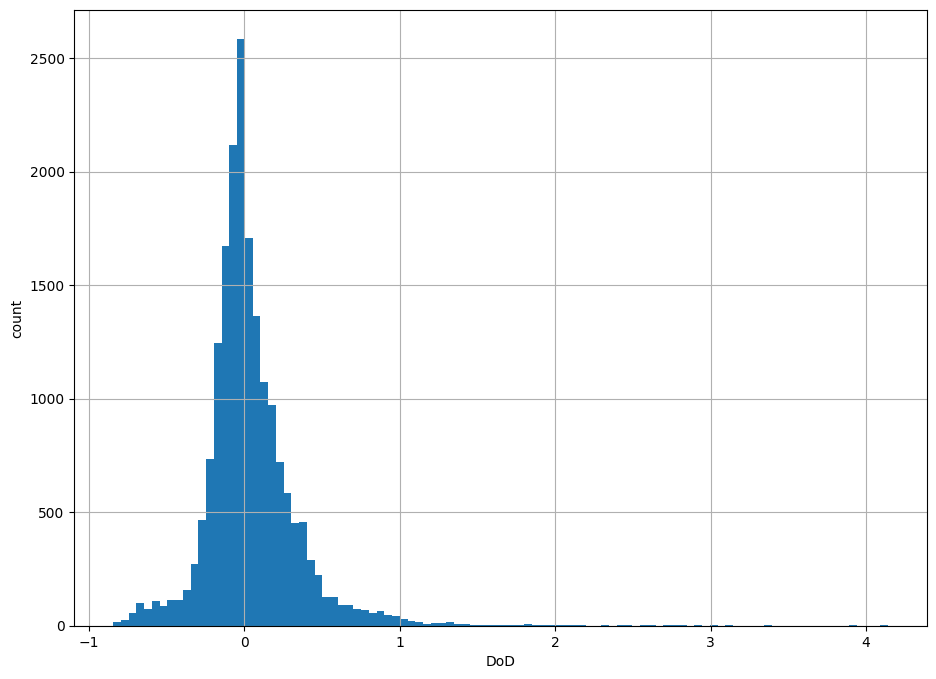

In [14]:
df['diff'].hist(bins=100)
plt.xlabel('DoD')
plt.ylabel('count')
plt.gcf().set_size_inches(11,8)

In [15]:
series.reshape(1,-1)

array([[ 0.38775565,  0.25000069,  0.        , ...,  0.10769204,
        -0.29166602, -0.16667034]])

# **Training and Testing**

In [16]:
values=series.reshape(-1,1)
scaler=MinMaxScaler(feature_range=(-1,1))
values=scaler.fit_transform(values)
x=values[:-1]
y=values[1:]

In [17]:
n_points=len(series)
train_points=int(2/3*n_points)+1
x_train,x_test=x[:train_points],x[train_points:]
y_train,y_test=y[:train_points],y[train_points:]
print("We have",len(x_train),"training points and",x_test.shape[0],"testing points")

We have 12517 training points and 6257 testing points


In [18]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print(x_train.shape)
print(x_test.shape)

(12517, 1, 1)
(6257, 1, 1)


**LSTM**

In [19]:
model=Sequential()
model.add(LSTM(4,input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 96        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nb_epoch=500
model.fit(x_train,y_train,epochs=nb_epoch)

Epoch 1/500
392/392 [==============================] - 4s 3ms/step - loss: 0.1202
Epoch 2/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 3/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0100
Epoch 4/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0098
Epoch 5/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0097
Epoch 6/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0096
Epoch 7/500
392/392 [==============================] - 1s 4ms/step - loss: 0.0095
Epoch 8/500
392/392 [==============================] - 1s 4ms/step - loss: 0.0094
Epoch 9/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 10/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 11/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 12/500
392/392 [==============================] - 1s 3ms/step - loss: 0.0093
Epoch 13/500


In [21]:
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)
df['LSTM_train_predict']=1
df['LSTM_test_predict']=1
df.loc[1:train_points+1,'LSTM_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
df.loc[train_points+2:,'LSTM_Test_predict'] =1+scaler.inverse_transform(y_test_pred)
df['LSTM_train_predict']=df.iloc[0]['co']*df['LSTM_train_predict'].cumprod()
df['LSTM_test_predict']=df.iloc[train_points+1]['co']*df['LSTM_test_predict'].cumprod()

196/196 [==============================] - 0s 903us/step


<ipython-input-21-7ced7295ba76>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[1:train_points+1,'LSTM_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
<ipython-input-21-7ced7295ba76>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[train_points+2:,'LSTM_Test_predict'] =1+scaler.inverse_transform(y_test_pred)


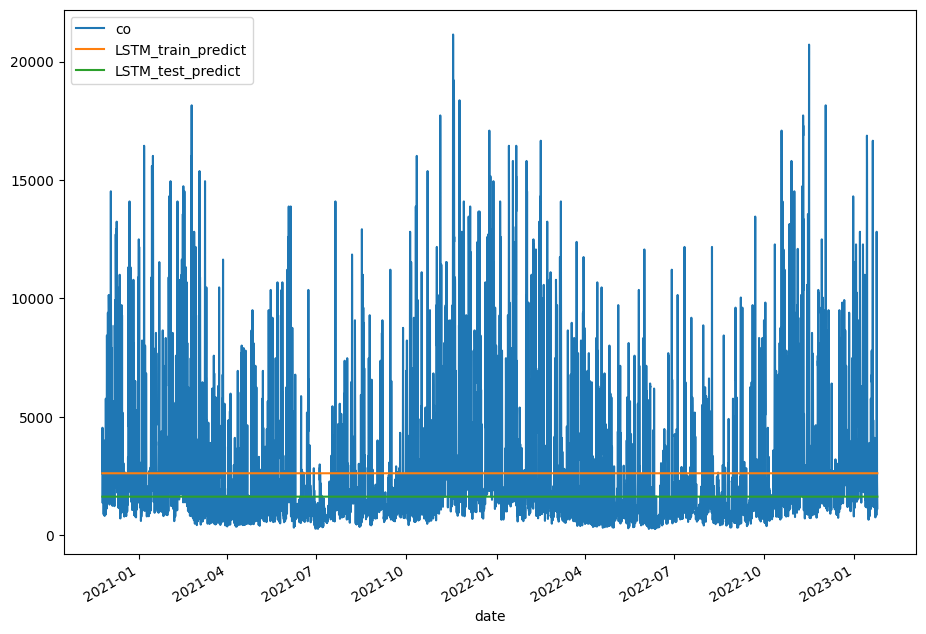

In [25]:
df[['co', 'LSTM_train_predict', 'LSTM_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)


In [27]:
X2=np.concatenate([x[0:-4],x[1:-3],x[2:-2],x[3:-1]],axis=1)
y2=x[4:]
x2_train, x2_test=X2[:train_points], X2[train_points:]
y2_train, y2_test=y2[:train_points], y2[train_points:]
print("We have",x2_train.shape[0],"training points and",x2_test.shape[0],"testing points")

We have 12517 training points and 6253 testing points


In [28]:
x2_train=x2_train.reshape(x2_train.shape[0],x2_train.shape[1],1)
x2_test=x2_test.reshape(x2_test.shape[0],x2_test.shape[1],1)
print(x2_train.shape)
print(x2_test.shape)

(12517, 4, 1)
(6253, 4, 1)


In [29]:
model=Sequential()
model.add(LSTM(units=10,input_shape=(x2_train.shape[1],x2_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [30]:
nb_epoch=500
model.fit(x2_train,y2_train,epochs=nb_epoch, batch_size=12)

Epoch 1/500
1044/1044 [==============================] - 4s 2ms/step - loss: 0.0320
Epoch 2/500
1044/1044 [==============================] - 3s 2ms/step - loss: 0.0125
Epoch 3/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0105
Epoch 4/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0092
Epoch 5/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0090
Epoch 6/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0089
Epoch 7/500
1044/1044 [==============================] - 3s 3ms/step - loss: 0.0088
Epoch 8/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0087
Epoch 9/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0087
Epoch 10/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0087
Epoch 11/500
1044/1044 [==============================] - 2s 2ms/step - loss: 0.0086
Epoch 12/500
1044/1044 [==============================] - 3s 3ms/step - lo

In [31]:
y_train_pred=model.predict(x2_train)
y_test_pred=model.predict(x2_test)
df['LSTM3_train_predict']=1
df['LSTM3_test_predict']=1
df.loc[4:train_points+4,'LSTM3_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
df.loc[train_points+6:,'LSTM3_Test_predict'] =1+scaler.inverse_transform(y_test_pred)
df['LSTM3_train_predict']=df.iloc[0]['co']*df['LSTM3_train_predict'].cumprod()
df['LSTM3_test_predict']=df.iloc[train_points+1]['co']*df['LSTM3_test_predict'].cumprod()

196/196 [==============================] - 0s 1ms/step


<ipython-input-31-36bc489fff33>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[4:train_points+4,'LSTM3_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
<ipython-input-31-36bc489fff33>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[train_points+6:,'LSTM3_Test_predict'] =1+scaler.inverse_transform(y_test_pred)


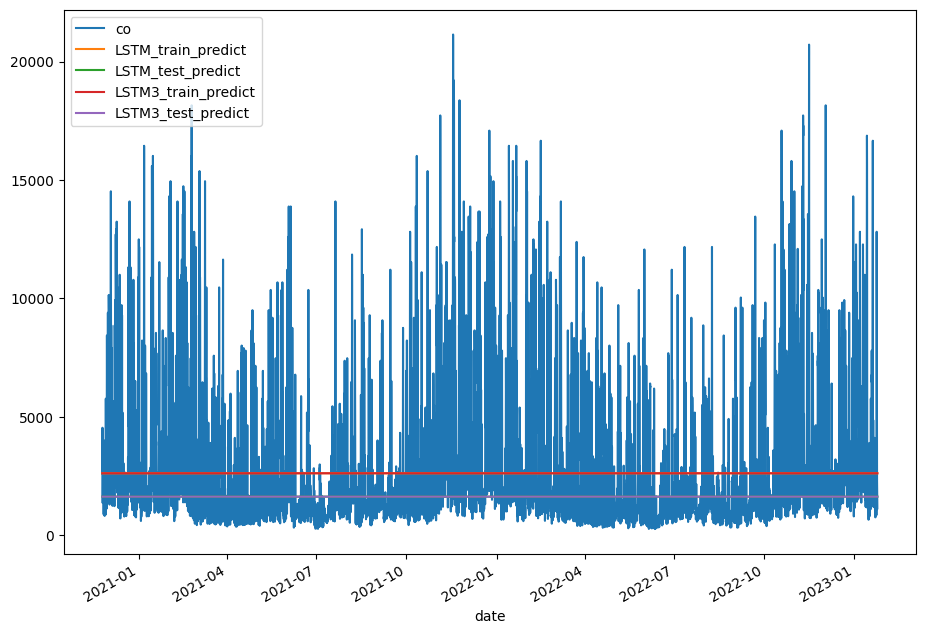

In [32]:
df[['co', 'LSTM_train_predict', 'LSTM_test_predict', 'LSTM3_train_predict', 'LSTM3_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)

# **GRU**

In [33]:
model=Sequential()
model.add(GRU(4,input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4)                 84        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


In [34]:
nb_epoch=500
model.fit(x_train,y_train,epochs=nb_epoch)

Epoch 1/500
392/392 [==============================] - 2s 2ms/step - loss: 0.1581
Epoch 2/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 3/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0122
Epoch 4/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 5/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0109
Epoch 6/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0103
Epoch 7/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0099
Epoch 8/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 9/500
392/392 [==============================] - 1s 1ms/step - loss: 0.0095
Epoch 10/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 11/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 12/500
392/392 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 13/500


In [35]:
y_train_pred=model.predict(x_train)
y_test_pred=model.predict(x_test)
df['GRU_train_predict']=1
df['GRU_test_predict']=1
df.loc[1:train_points+1,'GRU_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
df.loc[train_points+2:,'GRU_Test_predict'] =1+scaler.inverse_transform(y_test_pred)
df['GRU_train_predict']=df.iloc[0]['co']*df['GRU_train_predict'].cumprod()
df['GRU_test_predict']=df.iloc[train_points+1]['co']*df['GRU_test_predict'].cumprod()

196/196 [==============================] - 0s 911us/step


<ipython-input-35-ec9ff255d3c9>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[1:train_points+1,'GRU_Train_predict'] =1+scaler.inverse_transform(y_train_pred)
<ipython-input-35-ec9ff255d3c9>:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[train_points+2:,'GRU_Test_predict'] =1+scaler.inverse_transform(y_test_pred)


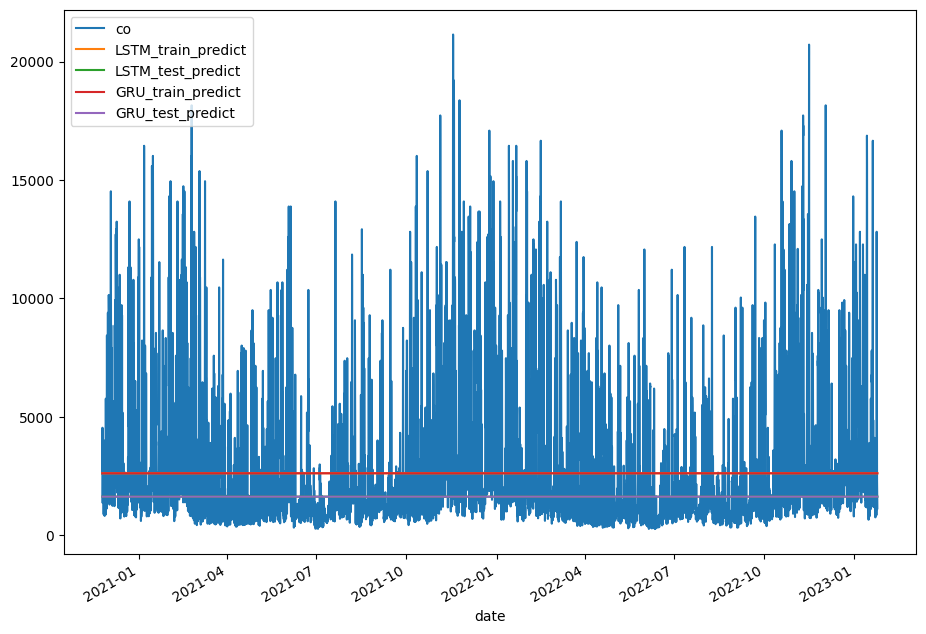

In [36]:
df[['co', 'LSTM_train_predict', 'LSTM_test_predict', 'GRU_train_predict', 'GRU_test_predict']].plot()
plt.gcf().set_size_inches(11, 8)